In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.training import train, optimization_step
from utils.diagnostic import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, loss, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

827784

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=4, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(model, loss, x_batch, y_batch, optimizer)

all_losses = train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator, n_epochs,
    patience=8, threshold=0.01,  # for early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.768 4.074  0.053 0.118  0.165 0.327  115.271
1  3.948 3.709  0.145 0.175  0.363 0.419  113.210
2  3.634 3.363  0.193 0.228  0.437 0.498  113.220
3  3.436 3.255  0.227 0.253  0.485 0.520  113.171
4  3.294 3.139  0.252 0.275  0.515 0.552  113.301
5  3.193 3.086  0.268 0.284  0.538 0.565  113.149
6  3.089 2.988  0.288 0.305  0.562 0.583  113.123
7  3.025 2.940  0.300 0.312  0.576 0.597  113.105
8  2.952 2.947  0.314 0.315  0.590 0.597  113.212
9  2.903 2.900  0.324 0.329  0.601 0.602  113.163
10  2.862 2.767  0.332 0.349  0.610 0.624  113.071
11  2.822 2.732  0.340 0.357  0.616 0.639  113.108
12  2.782 2.738  0.346 0.352  0.626 0.634  113.138
13  2.754 2.819  0.351 0.341  0.632 0.620  113.156
14  2.734 2.681  0.355 0.363  0.636 0.646  113.206
15  2.709 2.693  0.362 0.363  0.642 0.642  113.168
16  2.690 2.761  0.364 0.352  0.644 0.627  113.054
17  2.673 2.637  0.365 0.379  0.648 0.655  112.994
18  2.653 2.666  0.373 0.368  0.650 0.653  113.018
19  2.635 2.696  0.376 0.359  0.654 0.648

# Loss/epoch plots

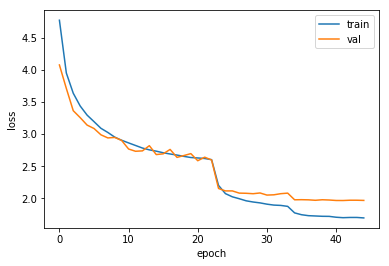

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

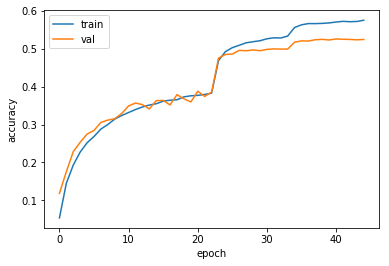

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

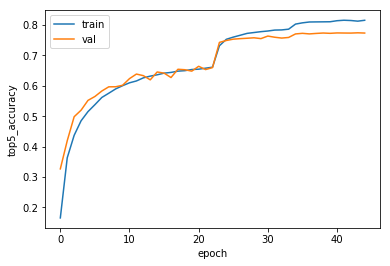

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')